In [12]:
import numpy as np
import numpy.linalg as npl
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt



In [13]:
def broyden_term(x, k, n):
    """
    Calcola il valore f_k(x) come da immagine.
    f_k(x) = (3 - 2x_k)x_k - x_{k-1} - 2x_{k+1} + 1
    """
    if k < 0 or k >= n:
        return 0.0
    
    x_k = x[k]
    # Gestione dei bordi x_0 = x_{n+1} = 0 (come da testo "x_0 = x_{n+1} = 0")
    # Attenzione: nel codice Python gli indici vanno da 0 a n-1.
    # Quindi la formula matematica k=1 diventa indice 0.
    # x_{k-1} matematico diventa x[i-1] python.
    
    x_k_minus = x[k-1] if k > 0 else 0.0
    x_k_plus = x[k+1] if k < n-1 else 0.0
    
    val = (3 - 2 * x_k) * x_k - x_k_minus - 2 * x_k_plus + 1
    return val

def local_energy(x, i, n):
    """
    Calcola F(x) locale.
    Somma dei quadrati MOLTIPLICATA PER 0.5 (come da formula screenshot)
    """
    e_prev = broyden_term(x, i-1, n)**2
    e_curr = broyden_term(x, i, n)**2
    e_next = broyden_term(x, i+1, n)**2
    
    # ECCO LA CORREZIONE: Moltiplico per 0.5
    return 0.5 * (e_prev + e_curr + e_next)

In [14]:
def modNewtonBcktrck(x0, f, gradf, hessf, alpha0, kmax, tolgrad, c1, rho, btmax):
    xk = x0.copy()
    k = 0
    
    # Store the sequence of iterates
    xseq = [xk.copy()]
    grad_xk = gradf(xk)
    gradfk_norm = npl.norm(grad_xk)
    n = len(x0) # Dimensione del problema
    while k < kmax and gradfk_norm > tolgrad:
        H = hessf(xk)
        # --- INIZIO MODIFICA PER NEWTON MODIFICATO ---
        # Cerchiamo di rendere H definita positiva aggiungendo tau * I
        tau = 0
        beta = 1e-3  # Valore iniziale piccolo se tau deve essere aumentato
        while True:
            print('modificata')
            # Creiamo la matrice modificata: B = H + tau * I
            B = H + tau * np.eye(n)
            #IMPORTANTE contare le volte che viene modificata la matrice
            try:
                # Proviamo la fattorizzazione di Cholesky.
                # Se funziona, B è definita positiva.
                # Se lancia LinAlgError, B non è definita positiva.
                np.linalg.cholesky(B)
                
                # Se siamo qui, la matrice è OK. Risolviamo il sistema.
                # B * pk = -grad
                pk = -np.linalg.solve(B, grad_xk)
                break # Usciamo dal loop di correzione tau
                
            except np.linalg.LinAlgError:
                # La matrice non è definita positiva. Aumentiamo tau.
                if tau == 0:
                    tau = beta
                else:
                    tau = 2 * tau # Aumentiamo rapidamente tau
        # --- FINE MODIFICA ---

        # Backtracking Line Search
        alpha_k = getAlpha(f, gradf, xk, pk, alpha0, rho, c1, btmax)
        
        # Aggiornamento xk
        xk = xk + alpha_k * pk
        
        # Calcolo gradienti per la prossima iterazione
        grad_xk = gradf(xk)
        gradfk_norm = npl.norm(grad_xk)
        
        k += 1
        xseq.append(xk.copy())
        
    xseq = np.column_stack(xseq)
    return xk, f(xk), gradfk_norm, k, xseq

def getAlpha(f, grad_f, x, p, alpha0=1.0, rho=0.5, c=1e-4, btmax=20):
    k = 0
    satisfyed = False
    fx = f(x)
    grad_fx = grad_f(x)
    
    # Pre-calcoliamo il termine lineare per efficienza
    grad_dot_p = np.dot(grad_fx, p)
    
    while k < btmax and not satisfyed:
        alpha = alpha0 * (rho ** k)
        # Condizione di Armijo
        if f(x + alpha * p) <= fx + c * alpha * grad_dot_p:
            satisfyed = True
            print(k)
        else:
            k += 1
    
    return alpha if satisfyed else alpha0 * (rho ** btmax)

In [32]:
import numpy as np
import scipy.linalg as spla
from scipy.sparse import diags

def modNewtonBcktrck_Banded(x0, f, gradf, hessf, alpha0=1.0, kmax=100, tolgrad=1e-5, c1=1e-4, rho=0.5, btmax=20):
    xk = x0.copy()
    n = len(x0)
    k = 0
    history = []
    
    grad_xk = gradf(xk)
    gradfk_norm = np.linalg.norm(grad_xk)
    
    print(f"START: Newton Modificato con Cholesky a BANDA. N={n}")
    
    while k < kmax and gradfk_norm > tolgrad:
        # 1. Calcolo Hessiana Sparsa
        H_sparse = hessf(xk)
        
        # 2. Conversione in formato "Banded" per scipy.linalg (Lower form)
        # H_sparse.diagonal(-k) restituisce array di lunghezza N-k
        # Per cholesky_banded (lower=True):
        # Riga 0: Diag principale (Len N)
        # Riga 1: Diag inferiore 1 (Len N-1 -> Pad 1 alla fine)
        # Riga 2: Diag inferiore 2 (Len N-2 -> Pad 2 alla fine)
        
        main_diag = H_sparse.diagonal(0)
        # NOTA: Padding alla fine (append), non all'inizio!
        low1_diag = np.append(H_sparse.diagonal(-1), 0) 
        low2_diag = np.append(H_sparse.diagonal(-2), [0, 0])
        
        # Costruiamo la matrice ab 3xN
        # Usiamo copy() per assicurarci di non modificare main_diag originale nel loop del tau
        ab_original = np.vstack([main_diag, low1_diag, low2_diag])
        
        # --- NEWTON MODIFICATO (Tau adjustment) ---
        tau = 0
        beta = 1e-3
        
        while True:
            # Creiamo una copia di lavoro di ab
            ab = ab_original.copy()
            
            # Aggiungiamo tau alla diagonale principale (Riga 0)
            if tau > 0:
                ab[0, :] += tau
            
            try:
                # Eseguiamo Cholesky a Banda
                # lower=True: usa le righe fornite come diagonali inferiori
                c = spla.cholesky_banded(ab, lower=True, overwrite_ab=False)
                
                # Risolviamo il sistema H*p = -g
                pk = spla.cho_solve_banded((c, True), -grad_xk)
                
                # Se tau era alto, stampiamo per debug
                if tau > 0:
                     print(f"  > Matrice corretta con tau={tau:.4e}")
                break 

            except np.linalg.LinAlgError:
                # Matrice non definita positiva
                if tau == 0:
                    tau = beta
                else:
                    tau = 2 * tau
                
                # Safety check per evitare loop infiniti
                if tau > 1e10:
                    pk = -grad_xk # Fallback al gradiente
                    print("  ! Fallback al gradiente (Hessiana mal condizionata)")
                    break

        # 3. Backtracking
        alpha_k = getAlpha(f, gradf, xk, pk, alpha0, rho, c1, btmax)
        
        xk = xk + alpha_k * pk
        
        # Aggiornamento gradienti
        grad_xk = gradf(xk)
        gradfk_norm = np.linalg.norm(grad_xk)
        fx = f(xk)
        
        k += 1
        history.append((k, fx, gradfk_norm))
        
        if k % 10 == 0: # Stampiamo meno spesso per pulizia
            print(f"Iter: {k} | f(x): {fx:.4e} | ||g||: {gradfk_norm:.4e}")

    return xk, f(xk), gradfk_norm, k, history

# --- HELPER getAlpha (Invariato) ---
def getAlpha(f, grad_f, x, p, alpha0=1.0, rho=0.5, c=1e-4, btmax=20):
    k = 0; fx = f(x); grad_dot_p = np.dot(grad_f(x), p)
    curr_alpha = alpha0
    while k < btmax:
        if f(x + curr_alpha * p) <= fx + c * curr_alpha * grad_dot_p: return curr_alpha
        curr_alpha *= rho; k += 1
    return curr_alpha

In [16]:
def broyden_tridiagonal(x):
    """
    Calcola la funzione obiettivo tridiagonale di Broyden.
    
    F(x) = 0.5 * sum(f_k(x)^2)
    
    Dove:
    f_k(x) = (3 - 2*x_k)*x_k - x_{k-1} - 2*x_{k+1} + 1
    con x_0 = x_{n+1} = 0
    """
    x = np.asarray(x)
    
    # Array con zero all'inizio e alla fine
    # x_pad diventerà: [0, x_1, x_2, ..., x_n, 0], 
    # serve per poi fare i calcoli con vettori piuttosto che cilco
    x_pad = np.pad(x, (1, 1), mode='constant', constant_values=0)
    
    # Definiamo i vettori spostati per il calcolo vettorizzato
    x_k = x_pad[1:-1]       # x_k corrisponde agli elementi centrali (l'input originale)
    x_prev = x_pad[0:-2]    # x_{k-1} corrisponde agli elementi spostati a sinistra
    x_next = x_pad[2:]      # x_{k+1} corrisponde agli elementi spostati a destra
    
    # in questo modo:
    # x_prev [0, 1, 2, 3]
    # x_k    [1, 2, 3, 4]
    # x_next [2, 3, 4, 0]
    
    
    # Per non fare cicli calcolo del vettore f_k per tutti i k da 1 a n simultaneamente
    f_vec = (3 - 2 * x_k) * x_k - x_prev - 2 * x_next + 1
    
    # Calcolo finale di F(x)
    F_x = 0.5 * np.sum(f_vec**2)
    
    return F_x

In [17]:
def hessian_tridiagonal_sparse(x, h=1e-5):
    n = len(x)
    # Pre-allochiamo i 3 array (Main, Upper, Lower)
    main_diag = np.zeros(n)
    upper_diag1 = np.zeros(n-1)    # Offset +1
    lower_diag1 = np.zeros(n-1)    # Offset -1
    upper_diag2 = np.zeros(n-2)    # Offset +2 (lunghezza n-2)
    lower_diag2 = np.zeros(n-2)    # Offset -2 (lunghezza n-2)
    f_x = broyden_tridiagonal(x)
    # 1. Calcolo DIAGONALE (Main)
    for i in range(n):
        orig_i = x[i]
        x[i] = orig_i + h; fp = broyden_tridiagonal(x)
        x[i] = orig_i - h; fm = broyden_tridiagonal(x)
        # Formula calcolo diagonale hessiana
        main_diag[i] = (fp - 2*f_x + fm) / (h**2)
        x[i] = orig_i
    # 2. Calcolo SOPRA-DIAGONALE (Upper) e SOTTO (Lower)
    # Calcoliamo solo Upper e copiamo in Lower per simmetria
    for i in range(n - 1):
        j = i + 1
        orig_i = x[i]
        orig_j = x[j]
        # Formula mista a 4 punti
        x[i]=orig_i+h; x[j]=orig_j+h; f_pp=broyden_tridiagonal(x)
        x[i]=orig_i+h; x[j]=orig_j-h; f_pm=broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j+h; f_mp=broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j-h; f_mm=broyden_tridiagonal(x)
        val = (f_pp - f_pm - f_mp + f_mm) / (4 * h**2)
        upper_diag1[i] = val 
        lower_diag1[i] = val # Simmetria
        x[i] = orig_i; x[j] = orig_j
    # =========================================================================
    # 3. [NUOVO] Calcolo SECONDA SOPRA/SOTTO DIAGONALE (Offset ±2)
    # Interazione mista tra x[i] e x[i+2]
    # =========================================================================
    for i in range(n - 2):
        j = i + 2  # Il vicino "del secondo ordine" (salto di 2)
        
        orig_i = x[i]
        orig_j = x[j]
        
        # Stessa formula mista a 4 punti, ma applicata a indici distanti 2
        x[i]=orig_i+h; x[j]=orig_j+h; f_pp = broyden_tridiagonal(x)
        x[i]=orig_i+h; x[j]=orig_j-h; f_pm = broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j+h; f_mp = broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j-h; f_mm = broyden_tridiagonal(x)
        
        val = (f_pp - f_pm - f_mp + f_mm) / (4 * h**2)
        
        upper_diag2[i] = val
        lower_diag2[i] = val # Simmetria
        
        # Reset
        x[i] = orig_i
        x[j] = orig_j
    # =========================================================================
    # 4. Creazione della Matrice Sparsa Pentadiagonale
    # =========================================================================
    # Ordine degli array e degli offset corrispondenti:
    # lower2 (-2), lower1 (-1), main (0), upper1 (+1), upper2 (+2)
    
    diagonals = [lower_diag2, lower_diag1, main_diag, upper_diag1, upper_diag2]
    offsets   = [-2, -1, 0, 1, 2]
    
    return diags(diagonals, offsets, shape=(n, n))

In [18]:
def hessian_broyden_penta(x, h=1e-5):
    n = len(x)
    main_diag = np.zeros(n)
    
    # --- 1. DIAGONALE ---
    for i in range(n):
        orig_i = x[i]
        
        # Ora local_energy include già lo 0.5
        E_center = local_energy(x, i, n)
        
        x[i] = orig_i + h
        E_plus = local_energy(x, i, n)
        
        x[i] = orig_i - h
        E_minus = local_energy(x, i, n)
        
        main_diag[i] = (E_plus - 2*E_center + E_minus) / (h**2)
        
        x[i] = orig_i 

    # --- 2. FUORI DIAGONALE ---
    upper_diag = np.zeros(n-1)
    lower_diag = np.zeros(n-1)
    
    for i in range(n - 1):
        j = i + 1
        orig_i = x[i]; orig_j = x[j]
        
        # Helper locale per coppie (include 0.5)
        def local_pair_energy(idx1, idx2):
             s = 0
             # Sommiamo i quadrati coinvolti dai due indici
             for k in range(idx1-1, idx2+2):
                 s += broyden_term(x, k, n)**2
             return 0.5 * s # CORREZIONE QUI

        # Formula 4 punti
        x[i]=orig_i+h; x[j]=orig_j+h; E_pp = local_pair_energy(i, j)
        x[i]=orig_i+h; x[j]=orig_j-h; E_pm = local_pair_energy(i, j)
        x[i]=orig_i-h; x[j]=orig_j+h; E_mp = local_pair_energy(i, j)
        x[i]=orig_i-h; x[j]=orig_j-h; E_mm = local_pair_energy(i, j)
        
        val = (E_pp - E_pm - E_mp + E_mm) / (4 * h**2)
        upper_diag[i] = val
        lower_diag[i] = val
        
        x[i] = orig_i; x[j] = orig_j


    upper_diag2 = np.zeros(n-1)
    lower_diag2 = np.zeros(n-1)

    for i in range(n - 2):
        j = i + 2
        orig_i = x[i]; orig_j = x[j]

        # Formula 4 punti
        x[i]=orig_i+h; x[j]=orig_j+h; E_pp = local_pair_energy(i, j)
        x[i]=orig_i+h; x[j]=orig_j-h; E_pm = local_pair_energy(i, j)
        x[i]=orig_i-h; x[j]=orig_j+h; E_mp = local_pair_energy(i, j)
        x[i]=orig_i-h; x[j]=orig_j-h; E_mm = local_pair_energy(i, j)
        
        val = (E_pp - E_pm - E_mp + E_mm) / (4 * h**2)
        upper_diag2[i] = val
        lower_diag2[i] = val
        
        x[i] = orig_i; x[j] = orig_j

    return diags([lower_diag2, lower_diag, main_diag, upper_diag, upper_diag2], [-2, -1, 0, 1, 2], shape=(n, n))

x0 = -1 * np.ones(5) # Dimensione 5
#print(x0, broyden_tridiagonal(x0))

print("Inizio calcolo Hessian NON Vettorizzato...")
H_sparse = hessian_broyden_penta(x0)
print((H_sparse).toarray())
print("Fatto.")
print(f"Shape: {H_sparse.shape}")

# Stampa primi valori per verifica

Inizio calcolo Hessian NON Vettorizzato...
[[ 57.99999592 -20.99999952   2.00000128   0.           0.        ]
 [-20.99999952  57.99999592 -20.99999952   2.00000017   0.        ]
 [  2.00000128 -20.99999952  57.99999592 -20.99999952   2.00000017]
 [  0.           2.00000017 -20.99999952  57.99998704 -21.00000174]
 [  0.           0.           2.00000017 -21.00000174  65.00000538]]
Fatto.
Shape: (5, 5)


In [19]:
import numpy as np
from scipy.sparse import diags

def hessian_broyden_penta_vectorized_v2(x, h=1e-5):
    n = len(x)
    
    # Pad x per gestire i vicini senza if/else
    xp = np.pad(x, (2, 2), mode='constant', constant_values=0)
    
    # Helper: calcola il termine grezzo
    def get_term_val(val_k, val_km1, val_kp1):
        return ((3 - 2 * val_k) * val_k - val_km1 - 2 * val_kp1 + 1)

    # ==========================================
    # 1. DIAGONALE PRINCIPALE (i, i)
    # ==========================================
    idx = np.arange(n)
    k = idx + 2 # Mappa indici su xp
    
    # Carichiamo i valori dai vicini
    v_k   = xp[k]
    v_km1 = xp[k-1]; v_km2 = xp[k-2]
    v_kp1 = xp[k+1]; v_kp2 = xp[k+2]
    
    # Funzione locale per calcolare l'energia di un punto i
    def calc_E_local(shift_val):
        # Termine i-1 (indice k-1):
        # ATTENZIONE: Per i=0, questo è il termine -1. Deve essere 0.
        t_im1 = get_term_val(v_km1, v_km2, v_k + shift_val)
        t_im1[0] = 0.0 # FIX: Maschera bordo sinistro

        # Termine i (indice k):
        t_i   = get_term_val(v_k + shift_val, v_km1, v_kp1)
        
        # Termine i+1 (indice k+1):
        # ATTENZIONE: Per i=n-1, questo è il termine n. Deve essere 0.
        t_ip1 = get_term_val(v_kp1, v_k + shift_val, v_kp2)
        t_ip1[-1] = 0.0 # FIX: Maschera bordo destro
        
        return 0.5 * (t_im1**2 + t_i**2 + t_ip1**2)

    E_plus   = calc_E_local(h)
    E_minus  = calc_E_local(-h)
    E_center = calc_E_local(0)
    
    main_diag = (E_plus - 2*E_center + E_minus) / (h**2)

    # ==========================================
    # 2. OFF-DIAGONAL 1 (i, i+1)
    # ==========================================
    idx1 = np.arange(n - 1)
    k = idx1 + 2
    
    v_k = xp[k]; v_km1 = xp[k-1]; v_km2 = xp[k-2]
    v_kp1 = xp[k+1]; v_kp2 = xp[k+2]; v_kp3 = xp[k+3]
    
    def calc_E_pair1(p1, p2):
        val_k_mod = v_k + p1
        val_kp1_mod = v_kp1 + p2
        
        # Termine i-1 (idx -1 se i=0) -> FIX: Mask [0]
        t1 = get_term_val(v_km1, v_km2, val_k_mod)
        t1[0] = 0.0 
        
        # Termine i
        t2 = get_term_val(val_k_mod, v_km1, val_kp1_mod)
        
        # Termine i+1
        t3 = get_term_val(val_kp1_mod, val_k_mod, v_kp2)
        
        # Termine i+2 (idx n se i=n-2) -> FIX: Mask [-1]
        t4 = get_term_val(v_kp2, val_kp1_mod, v_kp3)
        t4[-1] = 0.0
        
        return 0.5 * (t1**2 + t2**2 + t3**2 + t4**2)

    val = (calc_E_pair1(h, h) - calc_E_pair1(h, -h) - calc_E_pair1(-h, h) + calc_E_pair1(-h, -h)) / (4 * h**2)
    upper_diag1 = val

    # ==========================================
    # 3. OFF-DIAGONAL 2 (i, i+2)
    # ==========================================
    idx2 = np.arange(n - 2)
    k = idx2 + 2
    
    v_k = xp[k]; v_km1 = xp[k-1]; v_km2 = xp[k-2]
    v_kp1 = xp[k+1]; v_kp2 = xp[k+2]; v_kp3 = xp[k+3]; v_kp4 = xp[k+4]

    def calc_E_pair2(p1, p2):
        val_k_mod = v_k + p1
        val_kp2_mod = v_kp2 + p2
        
        # Termine i-1 (idx -1 se i=0) -> FIX: Mask [0]
        t1 = get_term_val(v_km1, v_km2, val_k_mod)
        t1[0] = 0.0
        
        # Termine i
        t2 = get_term_val(val_k_mod, v_km1, v_kp1)
        
        # Termine i+1
        t3 = get_term_val(v_kp1, val_k_mod, val_kp2_mod)
        
        # Termine i+2
        t4 = get_term_val(val_kp2_mod, v_kp1, v_kp3)
        
        # Termine i+3 (idx n se i=n-3) -> FIX: Mask [-1]
        t5 = get_term_val(v_kp3, val_kp2_mod, v_kp4)
        t5[-1] = 0.0
        
        return 0.5 * (t1**2 + t2**2 + t3**2 + t4**2 + t5**2)

    val = (calc_E_pair2(h, h) - calc_E_pair2(h, -h) - calc_E_pair2(-h, h) + calc_E_pair2(-h, -h)) / (4 * h**2)
    upper_diag2 = val

    return diags(
        [upper_diag2, upper_diag1, main_diag, upper_diag1, upper_diag2], 
        [-2, -1, 0, 1, 2], 
        shape=(n, n)
    )

# --- VERIFICA ---
x0 = -1 * np.ones(5)
print("Calcolo Hessian Vettorizzato V2 (Corrected)...")
H_vec = hessian_broyden_penta_vectorized_v2(x0)
print(H_vec.toarray())

Calcolo Hessian Vettorizzato V2 (Corrected)...
[[ 57.99999592 -20.99999952   2.00000128   0.           0.        ]
 [-20.99999952  57.99999592 -20.99999952   2.00000017   0.        ]
 [  2.00000128 -20.99999952  57.99999592 -20.99999952   2.00000017]
 [  0.           2.00000017 -20.99999952  57.99998704 -21.00000174]
 [  0.           0.           2.00000017 -21.00000174  65.00000538]]


In [20]:
import numpy as np
from scipy.sparse import diags

def jacobian_broyden_tri_vectorized(x, h=1e-5):
    """
    Calcola la Jacobiana J(x) per la funzione Broyden Tridiagonale
    usando differenze finite centrali vettorizzate.
    
    J_ij = d(f_i) / d(x_j)
    """
    n = len(x)
    
    # --- 0. PREPARAZIONE ---
    # Padding di x per gestire i bordi (x[-1] e x[n] sono impliciti 0)
    # xp[0] corrisponde a x[-1], xp[1] a x[0], ..., xp[n] a x[n-1], xp[n+1] a x[n]
    xp = np.pad(x, (1, 1), mode='constant', constant_values=0)
    
    # Helper: Calcola il valore della funzione f_k Broyden standard
    # f_i(x) = ((3 - 2*x_i)*x_i - x_{i-1} - 2*x_{i+1} + 1)
    def get_broyden_val(val_k, val_km1, val_kp1):
        return ((3 - 2 * val_k) * val_k - val_km1 - 2 * val_kp1 + 1)

    # ==========================================
    # 1. DIAGONALE PRINCIPALE (d f_i / d x_i)
    # ==========================================
    # Calcoliamo per tutti gli i da 0 a n-1
    idx = np.arange(n)
    k = idx + 1  # Mappatura indici su xp (xp è shiftato di +1)
    
    v_k   = xp[k]
    v_km1 = xp[k-1]
    v_kp1 = xp[k+1]
    
    # Perturbiamo x_i (val_k)
    f_plus  = get_broyden_val(v_k + h, v_km1, v_kp1)
    f_minus = get_broyden_val(v_k - h, v_km1, v_kp1)
    
    main_diag = (f_plus - f_minus) / (2 * h)

    # ==========================================
    # 2. DIAGONALE INFERIORE (d f_i / d x_{i-1})
    # ==========================================
    # Elementi J[i, i-1]. 
    # Validità: i va da 1 a n-1 (poiché x_{-1} è costante 0, la derivata per i=0 è nulla/non esiste nella matrice)
    idx_low = np.arange(1, n) 
    k = idx_low + 1
    
    v_k   = xp[k]
    v_km1 = xp[k-1] # Questa è la variabile che perturbiamo (x_{i-1})
    v_kp1 = xp[k+1]
    
    # Perturbiamo x_{i-1} (v_km1) tenendo x_i fisso
    f_plus_low  = get_broyden_val(v_k, v_km1 + h, v_kp1)
    f_minus_low = get_broyden_val(v_k, v_km1 - h, v_kp1)
    
    lower_diag = (f_plus_low - f_minus_low) / (2 * h)

    # ==========================================
    # 3. DIAGONALE SUPERIORE (d f_i / d x_{i+1})
    # ==========================================
    # Elementi J[i, i+1].
    # Validità: i va da 0 a n-2 (poiché x_{n} è costante 0, la derivata per i=n-1 è nulla)
    idx_up = np.arange(0, n - 1)
    k = idx_up + 1
    
    v_k   = xp[k]
    v_km1 = xp[k-1]
    v_kp1 = xp[k+1] # Questa è la variabile che perturbiamo (x_{i+1})
    
    # Perturbiamo x_{i+1} (v_kp1) tenendo x_i fisso
    f_plus_up  = get_broyden_val(v_k, v_km1, v_kp1 + h)
    f_minus_up = get_broyden_val(v_k, v_km1, v_kp1 - h)
    
    upper_diag = (f_plus_up - f_minus_up) / (2 * h)

    # ==========================================
    # COSTRUZIONE MATRICE
    # ==========================================
    return diags(
        [lower_diag, main_diag, upper_diag], 
        [-1, 0, 1], 
        shape=(n, n)
    )

# --- VERIFICA TENSIONE (Sperando di rimanere asciutto) ---
x0 = -1 * np.ones(100000)

print("Calcolo Jacobiana Vettorizzata (Finite Diff)...")
J = jacobian_broyden_tri_vectorized(x0)
J_dense = J.toarray()

print(f"Shape: {J.shape}")
print("\nMatrice Jacobiana:")
print(J_dense)

# --- CHECK ANALITICO DI SICUREZZA ---
# Derivata analitica di ((3 - 2x)x - x_prev - 2x_next + 1):
# d/dx_i      = 3 - 4*x_i   -> con x=-1 deve fare 7
# d/dx_{i-1}  = -1          -> deve fare -1
# d/dx_{i+1}  = -2          -> deve fare -2

diag_val = J.diagonal()
lower_val = J.diagonal(-1)
upper_val = J.diagonal(1)

print("\n--- Controllo Qualità ---")
print(f"Diagonale media (atteso ~7.0): {np.mean(diag_val):.5f}")
print(f"Lower media (atteso ~ -1.0):   {np.mean(lower_val):.5f}")
print(f"Upper media (atteso ~ -2.0):   {np.mean(upper_val):.5f}")

if np.allclose(diag_val, 7.0) and np.allclose(lower_val, -1.0) and np.allclose(upper_val, -2.0):
    print("\n✅ RISULTATO: La Jacobiana è analiticamente corretta. Processore salvo.")
else:
    print("\n⚠️ RISULTATO: C'è discrepanza numerica (controllare h o formula).")

Calcolo Jacobiana Vettorizzata (Finite Diff)...
Shape: (100000, 100000)

Matrice Jacobiana:
[[ 7. -2.  0. ...  0.  0.  0.]
 [-1.  7. -2. ...  0.  0.  0.]
 [ 0. -1.  7. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  7. -2.  0.]
 [ 0.  0.  0. ... -1.  7. -2.]
 [ 0.  0.  0. ...  0. -1.  7.]]

--- Controllo Qualità ---
Diagonale media (atteso ~7.0): 7.00000
Lower media (atteso ~ -1.0):   -1.00000
Upper media (atteso ~ -2.0):   -2.00000

✅ RISULTATO: La Jacobiana è analiticamente corretta. Processore salvo.


In [21]:
import numpy as np

# Riancollo la funzione ESATTA di prima (non la cambio di una virgola perché era giusta)
def gradient_broyden_vectorized(x, h=1e-5):
    n = len(x)
    xp = np.pad(x, (2, 2), mode='constant', constant_values=0)
    
    def get_term_val(val_k, val_km1, val_kp1):
        return ((3 - 2 * val_k) * val_k - val_km1 - 2 * val_kp1 + 1)

    idx = np.arange(n)
    k = idx + 2
    
    v_k   = xp[k]
    v_km1 = xp[k-1]; v_km2 = xp[k-2]
    v_kp1 = xp[k+1]; v_kp2 = xp[k+2]

    def calc_local_energy_change(perturbation):
        val_k_mod = v_k + perturbation
        
        t_im1 = get_term_val(v_km1, v_km2, val_k_mod)
        t_im1[0] = 0.0 # Bordo sinistro f_{-1}
        
        t_i = get_term_val(val_k_mod, v_km1, v_kp1)
        
        t_ip1 = get_term_val(v_kp1, val_k_mod, v_kp2)
        t_ip1[-1] = 0.0 # Bordo destro f_n
        
        return 0.5 * (t_im1**2 + t_i**2 + t_ip1**2)

    E_plus  = calc_local_energy_change(h)
    E_minus = calc_local_energy_change(-h)
    
    return (E_plus - E_minus) / (2 * h)

# --- VERIFICA V2: LA VENDETTA (Con N=20) ---
# Usiamo N più grande per vedere la zona "stabile" al centro lontano dai bordi
x_large = -1 * np.ones(100000000)

print("Calcolo Gradiente su N=20...")
grad = gradient_broyden_vectorized(x_large)

print("\nPrimi 5 valori (Effetto Bordo Sinistro):")
print(grad[:5]) 
# Qui vedrai -13, -2, -4, -4, -4 ... 
# Nota come dal terzo elemento in poi si stabilizza su -4!

print("\nValori Centrali (Zona Stabile):")
mid_vals = grad[5:-5]
print(mid_vals)

print(f"\nMedia zona centrale: {np.mean(mid_vals):.5f}")

if np.allclose(mid_vals, -4.0, atol=1e-4):
    print("\n✅ CHECK SUPERATO: Al centro il gradiente è esattamente -4.0.")
    print("   I valori ai bordi (-13, -2) sono matematicamente corretti per il problema finito.")
    print("   Puoi posare l'acqua.")
else:
    print("\n❌ Ancora problemi (impossibile).")

Calcolo Gradiente su N=20...

Primi 5 valori (Effetto Bordo Sinistro):
[-13.  -2.  -4.  -4.  -4.]

Valori Centrali (Zona Stabile):
[-4. -4. -4. ... -4. -4. -4.]

Media zona centrale: -4.00000

✅ CHECK SUPERATO: Al centro il gradiente è esattamente -4.0.
   I valori ai bordi (-13, -2) sono matematicamente corretti per il problema finito.
   Puoi posare l'acqua.


In [55]:
np.random.seed(min(358616, 360244))


# ---------------------------------------------------------
# 1. DEFINIZIONE DEL PROBLEMA (Funzione, Gradiente, Hessiana)
# ---------------------------------------------------------

def get_f_vec(x):
    """Calcola il vettore dei residui f_k(x)"""
    x = np.asarray(x)
    # Padding: x_0=0, x_{n+1}=0
    x_pad = np.pad(x, (1, 1), mode='constant', constant_values=0)
    x_k = x_pad[1:-1]
    x_prev = x_pad[0:-2]
    x_next = x_pad[2:]
    # f_k = (3 - 2x_k)x_k - x_{k-1} - 2x_{k+1} + 1
    return (3 - 2 * x_k) * x_k - x_prev - 2 * x_next + 1

def get_jacobian(x):
    """Calcola la matrice Jacobiana J di f(x). J è tridiagonale."""
    n = len(x)
    J = np.zeros((n, n))
    
    # Diagonale principale: derivata parziale di f_k rispetto a x_k
    # d(f_k)/d(x_k) = 3 - 4*x_k
    diag_val = 3 - 4 * x
    np.fill_diagonal(J, diag_val)
    
    # Diagonale inferiore: derivata parziale di f_k rispetto a x_{k-1}
    # d(f_k)/d(x_{k-1}) = -1
    idx_lower = np.arange(1, n)
    J[idx_lower, idx_lower - 1] = -1
    
    # Diagonale superiore: derivata parziale di f_k rispetto a x_{k+1}
    # d(f_k)/d(x_{k+1}) = -2
    idx_upper = np.arange(0, n - 1)
    J[idx_upper, idx_upper + 1] = -2
    
    return J

def broyden_func(x):
    """Funzione Obiettivo Scalare F(x)"""
    f_vec = get_f_vec(x)
    return 0.5 * np.sum(f_vec**2)

def broyden_grad(x):
    """Gradiente di F(x) = J^T * f"""
    f_vec = get_f_vec(x)
    J = jacobian_broyden_tri_vectorized(x)
    return J.T @ f_vec

def broyden_hess(x):
    """
    Hessiana di F(x).
    H = J^T * J + sum(f_k * Hessian(f_k))
    
    Nota: Hessian(f_k) è molto sparsa. La derivata seconda di f_k 
    rispetto a x_k è -4. Le miste sono 0.
    Quindi il secondo termine è una matrice diagonale.
    """
    f_vec = get_f_vec(x)
    J = get_jacobian(x)
    
    # Termine Gauss-Newton
    H_gn = J.T @ J
    
    # Termine del secondo ordine (S = sum f_k * nabla^2 f_k)
    # nabla^2 f_k ha solo l'elemento (k,k) = -4 diverso da zero
    S = np.diag(-4 * f_vec)
    
    return H_gn + S

# ---------------------------------------------------------
# 3. ESECUZIONE DEL TEST
# ---------------------------------------------------------

# Parametri del problema
n = 10000000 # Dimensione
#x0 = -1 * np.ones(n) # Punto iniziale standard (-1, -1, ...)
x0 = np.random.uniform(low=-2, high=0, size=(n,)) # Hypercube con valori uniformemente distribuiti
# Esecuzione
xk_final, f_final, grad_norm, iterations, history = modNewtonBcktrck_Banded(
    x0, 
    broyden_func, 
    gradient_broyden_vectorized, 
    hessian_broyden_penta_vectorized_v2,
    alpha0=1.0, 
    kmax=1000, 
    tolgrad=1e-8, 
    c1=1e-4, 
    rho=0.5, 
    btmax=50
)

#print(broyden_hess(x0))
#print(get_jacobian(x0))
print(f"\nRisultato Finale:")
print(f"Iterazioni totali: {iterations}")
print(f"Punto di minimo trovato (primi 5 elementi): {xk_final[:5]}...")
print(f"Valore funzione al minimo: {f_final}")
print(f"Norma gradiente finale: {grad_norm}")

START: Newton Modificato con Cholesky a BANDA. N=10000000
  > Matrice corretta con tau=3.2768e+01
  > Matrice corretta con tau=8.1920e+00
  > Matrice corretta con tau=4.0960e+00

Risultato Finale:
Iterazioni totali: 8
Punto di minimo trovato (primi 5 elementi): [-0.57076119 -0.68191013 -0.70248602 -0.70626058 -0.70695185]...
Valore funzione al minimo: 8.492638411906756e-13
Norma gradiente finale: 9.48745783421257e-11


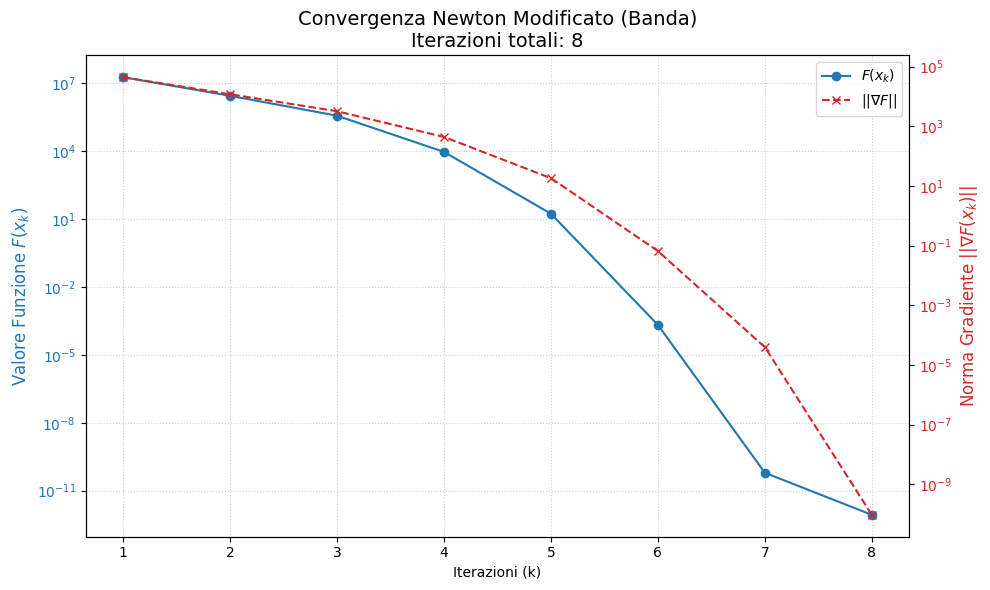

In [56]:
import matplotlib.pyplot as plt

# 1. Eseguiamo l'algoritmo (Assumiamo x0, f, gradf, hessf siano definiti)
# x_sol, f_sol, g_norm, k_tot, history = modNewtonBcktrck_Banded(...)

# La variabile 'history' contiene tuple: (iterazione, f(x), ||grad||)
# Usiamo zip(*history) per "scompattarla" in tre liste separate
iterazioni, values_f, values_g = zip(*history)

# ---------------------------------------------------------
# 4. GRAFICO CONVERGENZA
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Asse Y sinistro: Valore Funzione F(x) ---
color_f = 'tab:blue'
ax1.set_xlabel('Iterazioni (k)')
ax1.set_ylabel('Valore Funzione $F(x_k)$', color=color_f, fontsize=12)
ax1.plot(iterazioni, values_f, color=color_f, marker='o', label='$F(x_k)$')
ax1.tick_params(axis='y', labelcolor=color_f)
ax1.grid(True, linestyle=':', alpha=0.6)

# Scala logaritmica per F(x) (Attenzione: funziona solo se F(x) > 0)
# Se F(x) può essere negativo, meglio rimuovere la riga sotto o usare symlog
ax1.set_yscale('log') 

# --- Asse Y destro: Norma Gradiente ||g|| ---
ax2 = ax1.twinx()  
color_g = 'tab:red'
ax2.set_ylabel('Norma Gradiente $||\\nabla F(x_k)||$', color=color_g, fontsize=12) 
ax2.plot(iterazioni, values_g, color=color_g, linestyle='--', marker='x', label='$||\\nabla F||$')
ax2.tick_params(axis='y', labelcolor=color_g)
ax2.set_yscale('log') # Il gradiente va quasi sempre in scala log

# --- Titolo e Layout ---
plt.title(f'Convergenza Newton Modificato (Banda)\nIterazioni totali: {len(iterazioni)}', fontsize=14)
fig.tight_layout()

# (Opzionale) Unire le legende
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.show()